# 1. BTC/USD Dataset (Data split 7:3)

In [1]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [3]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [4]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [5]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [6]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [7]:
split_size1 = int(0.7 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [8]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [9]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 101481.5781 - mae: 101481.5781 - mse: 50404569088.0000 - val_loss: 88788.4219 - val_mae: 88788.4219 - val_mse: 9463183360.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step - loss: 52399.1406 - mae: 52399.1406 - mse: 4871116288.0000 - val_loss: 38075.1953 - val_mae: 38075.1953 - val_mse: 1774162048.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - loss: 24735.2266 - mae: 24735.2266 - mse: 1037761600.0000 - val_loss: 2037.6316 - val_mae: 2037.6316 - val_mse: 7153466.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 1633.5736 - mae: 1633.5736 - mse: 6994900.0000 - val_loss: 14356.5488 - val_mae: 14356.5488 - val_mse: 250629136.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - loss: 8251.1680 - mae: 8251.1680 - mse: 131670160.0000 - val_loss: 3069.2490 - val_mae: 3069.2490 - val_mse: 13703516.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - loss: 1975.0679 - mae: 1975.0679 - mse: 9672283.

In [10]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


array([21459.416, 21096.635, 20628.412, 18592.334, 16604.182, 17306.18 ,
       16996.203, 16382.049, 16941.895, 16729.168], dtype=float32)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.8451110587010437
RMSE: 1109.9980197615457
MAE: 696.1219610872168


In [12]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [13]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 68629.125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [69440.    68374.    67652.4   68352.2   67548.    67768.5   68629.125] -> Prediction: 69468.7265625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [68374.        67652.4       68352.2       67548.        67768.5
 68629.125     69468.7265625] -> Prediction: 68464.2890625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       68629.125
 69468.7265625 68464.2890625] -> Prediction: 68412.21875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [68352.2       67548.        67768.5       68629.125     69468.7265625
 68464.2890625 68412.21875  ] -> Prediction: 68900.03125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

In [14]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [15]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

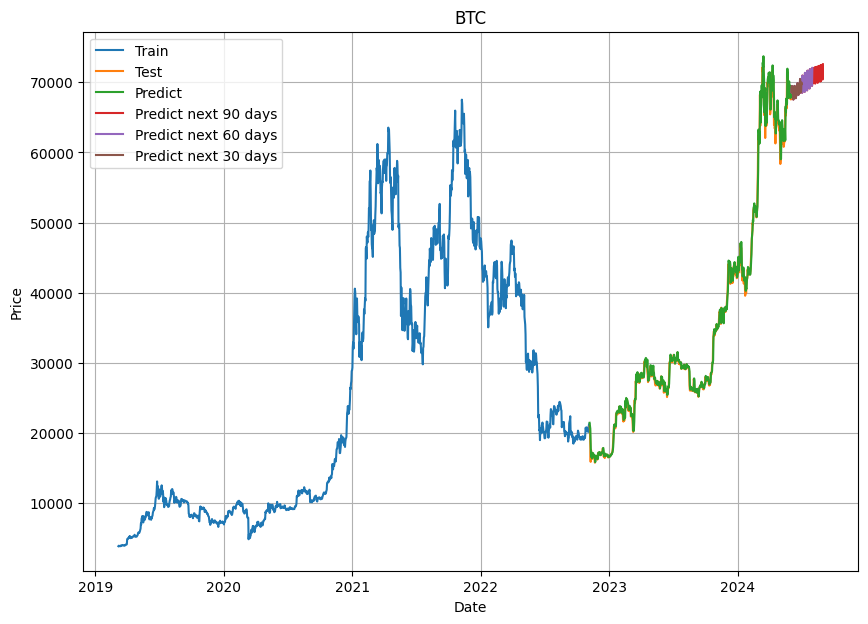

In [16]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 2. ETH/USD Dataset (Data split 7:3)

In [160]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [161]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [162]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [163]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [164]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [165]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [166]:
split_size1 = int(0.7 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [167]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [168]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 5886.3999 - mae: 5886.3999 - mse: 162617600.0000 - val_loss: 5420.5571 - val_mae: 5420.5571 - val_mse: 32667574.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 2731.8191 - mae: 2731.8191 - mse: 18332340.0000 - val_loss: 1356.1071 - val_mae: 1356.1071 - val_mse: 2143809.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - loss: 978.8012 - mae: 978.8012 - mse: 2081412.3750 - val_loss: 781.7159 - val_mae: 781.7159 - val_mse: 702931.3125
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 409.1494 - mae: 409.1494 - mse: 423446.5625 - val_loss: 1689.0214 - val_mae: 1689.0214 - val_mse: 3227417.5000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 623ms/step - loss: 930.2546 - mae: 930.2546 - mse: 2013955.0000 - val_loss: 86.1329 - val_mae: 86.1329 - val_mse: 15056.6934
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 96.8892 - mae: 96.8892 - mse: 30505.6211 - val_loss: 1037.5952 - val_mae: 1037.5952 - val_

In [169]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step


array([1625.6675, 1590.144 , 1566.321 , 1370.0059, 1218.8396, 1263.224 ,
       1273.3281, 1203.1765, 1293.8226, 1297.525 ], dtype=float32)

In [170]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.049798850787539
RMSE: 70.20934442357375
MAE: 43.860817352188576


In [171]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [172]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3827.19482421875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3827.19482422] -> Prediction: 3870.3251953125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3827.19482422 3870.32519531] -> Prediction: 3828.969482421875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3827.19482422
 3870.32519531 3828.96948242] -> Prediction: 3783.369384765625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3827.19482422 3870.32519531
 3828.96948242 3783.36938477] -> Prediction

In [173]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [174]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

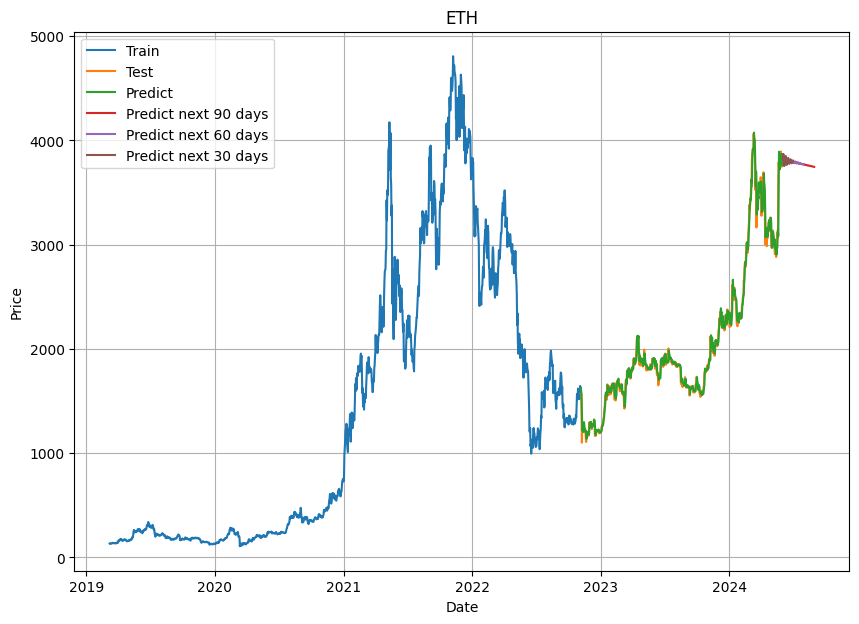

In [175]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. BNB/USD Dataset (Data split 7:3)

In [107]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [110]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [111]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [112]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [113]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [114]:
split_size1 = int(0.7 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [115]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [116]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 810.4099 - mae: 810.4099 - mse: 2907030.0000 - val_loss: 651.5914 - val_mae: 651.5914 - val_mse: 479533.6562
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - loss: 290.8599 - mae: 290.8599 - mse: 226896.4531 - val_loss: 349.6350 - val_mae: 349.6350 - val_mse: 140515.5625
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step - loss: 181.3237 - mae: 181.3237 - mse: 84604.3828 - val_loss: 121.0180 - val_mae: 121.0180 - val_mse: 16872.8809
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - loss: 49.5405 - mae: 49.5405 - mse: 7747.1914 - val_loss: 13.3202 - val_mae: 13.3202 - val_mse: 300.2935
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - loss: 10.5363 - mae: 10.5363 - mse: 532.1218 - val_loss: 78.5862 - val_mae: 78.5862 - val_mse: 7186.9307
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 673ms/step - loss: 40.8711 - mae: 40.8711 - mse: 4025.7429 - val_loss: 13.4280 - val_mae: 13.4280 - val_mse: 371.9520
Epoch 7/100
2/2 ━━━━━━━━━━━━

In [117]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


array([356.8718 , 347.62125, 336.97122, 329.98438, 281.42084, 290.61102,
       291.30606, 292.40027, 275.41968, 282.43253], dtype=float32)

In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.014326471587577
RMSE: 11.080686551980678
MAE: 6.714998703800426


In [119]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [120]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 603.9065551757812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        603.90655518] -> Prediction: 605.75244140625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 603.90655518 605.75244141] -> Prediction: 603.034423828125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        603.90655518
 605.75244141 603.03442383] -> Prediction: 597.9439086914062

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 [595.         593.8        601.8        603.90655518 605.75244141
 603.03442383 597.94390869] -> Prediction: 598.0007934570312

1/1 ━━━━━━━━━━━━━━━━━━━

In [121]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [122]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

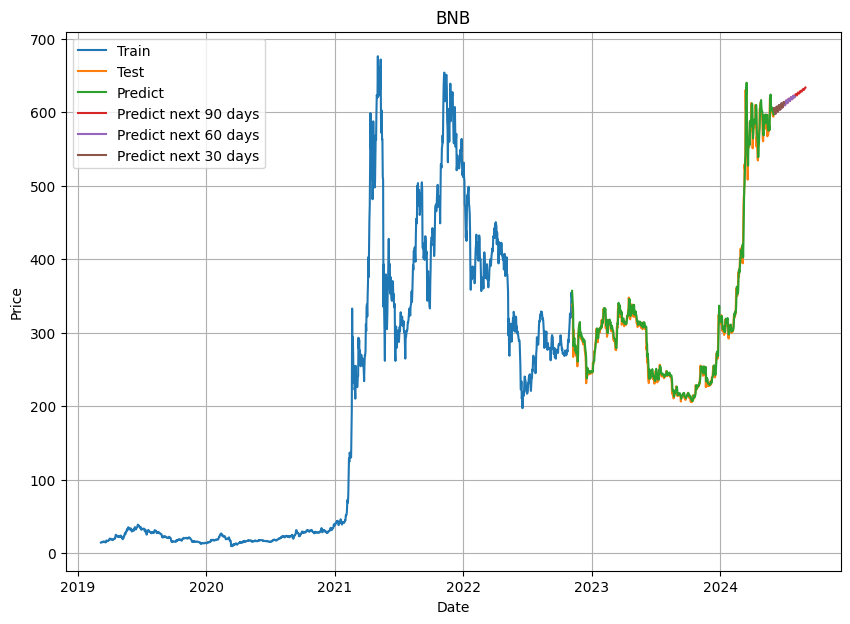

In [124]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 4. BTC/USD Dataset (Data split 8:2)

In [17]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [19]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [20]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [21]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [22]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [23]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [24]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [25]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 115933.6562 - mae: 115933.6562 - mse: 47813476352.0000 - val_loss: 115408.1250 - val_mae: 115408.1250 - val_mse: 15135479808.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - loss: 53783.5352 - mae: 53783.5352 - mse: 5428106240.0000 - val_loss: 23103.0723 - val_mae: 23103.0723 - val_mse: 649166528.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - loss: 12665.4736 - mae: 12665.4736 - mse: 276985664.0000 - val_loss: 18655.4570 - val_mae: 18655.4570 - val_mse: 410580928.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 10086.4375 - mae: 10086.4375 - mse: 181879008.0000 - val_loss: 4406.8765 - val_mae: 4406.8765 - val_mse: 34136896.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - loss: 6207.7578 - mae: 6207.7578 - mse: 98646296.0000 - val_loss: 7050.9380 - val_mae: 7050.9380 - val_mse: 62760892.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - loss: 3497.1113 - mae: 3497.1113 - mse: 2462

In [26]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


array([26404.975, 26243.451, 26525.07 , 26049.781, 25856.814, 26391.203,
       25979.691, 26227.162, 26400.719, 25705.775], dtype=float32)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 3.521919214526567
RMSE: 1934.1318565138681
MAE: 1522.2498470137075


In [28]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [29]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 66170.171875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on: 
 [69440.       68374.       67652.4      68352.2      67548.
 67768.5      66170.171875] -> Prediction: 67109.671875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicting on: 
 [68374.       67652.4      68352.2      67548.       67768.5
 66170.171875 67109.671875] -> Prediction: 65543.0703125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       66170.171875
 67109.671875  65543.0703125] -> Prediction: 65742.5078125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [68352.2       67548.        67768.5       66170.171875  67109.671875
 65543.0703125 65742.5078125] -> Prediction: 65411.140625

1/1 ━━━━━━━━━━

In [30]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [31]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

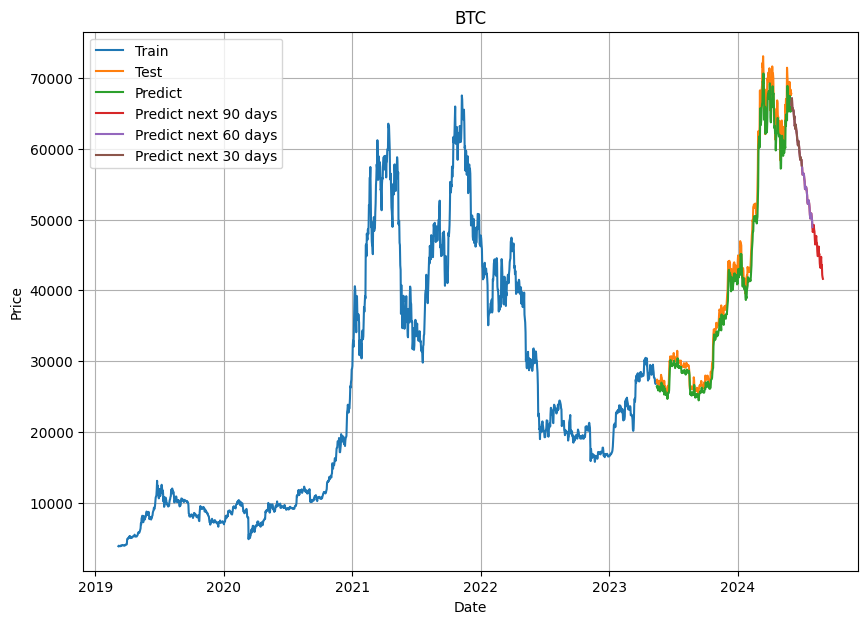

In [32]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 5. ETH/USD Dataset (Data split 8:2)

In [176]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [177]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [178]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [179]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [180]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [181]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [182]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [183]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [184]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 7781.3340 - mae: 7781.3340 - mse: 250696784.0000 - val_loss: 7466.2930 - val_mae: 7466.2930 - val_mse: 60628104.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 3245.9382 - mae: 3245.9382 - mse: 25655652.0000 - val_loss: 1649.1547 - val_mae: 1649.1547 - val_mse: 3114707.2500
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 777ms/step - loss: 928.3819 - mae: 928.3819 - mse: 1838889.6250 - val_loss: 186.2321 - val_mae: 186.2321 - val_mse: 57171.4922
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 746ms/step - loss: 132.2929 - mae: 132.2929 - mse: 56819.0391 - val_loss: 1430.0891 - val_mae: 1430.0891 - val_mse: 2246672.5000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 762ms/step - loss: 637.7655 - mae: 637.7655 - mse: 1011449.3125 - val_loss: 498.4062 - val_mae: 498.4062 - val_mse: 285168.0625
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 775ms/step - loss: 280.3836 - mae: 280.3836 - mse: 165430.8438 - val_loss: 434.3679 - val_mae: 434.3679 - val_m

In [185]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step


array([1820.7456, 1829.902 , 1838.8926, 1820.0652, 1823.7367, 1829.2412,
       1818.6382, 1826.9221, 1857.0399, 1823.448 ], dtype=float32)

In [186]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.022728041602878
RMSE: 78.08398135833606
MAE: 50.4241617243595


In [187]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [188]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3858.684326171875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3858.68432617] -> Prediction: 3909.27294921875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3858.68432617 3909.27294922] -> Prediction: 3839.69677734375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3858.68432617
 3909.27294922 3839.69677734] -> Prediction: 3791.3056640625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3858.68432617 3909.27294922
 3839.69677734 3791.30566406] -> Prediction:

In [189]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [190]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

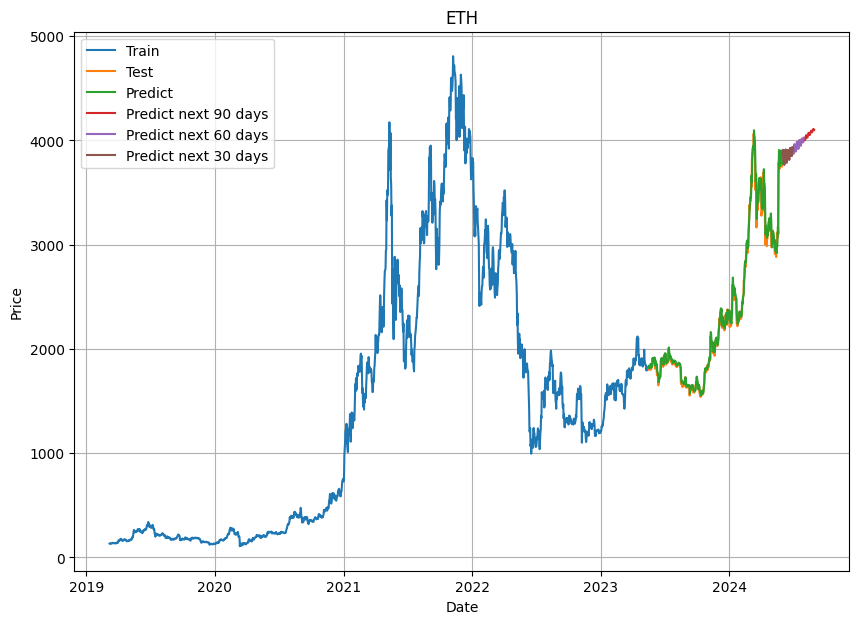

In [191]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 6. BNB/USD Dataset (Data split 8:2)

In [125]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [126]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [127]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [128]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [129]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [130]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [133]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [134]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [135]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 2297.0635 - mae: 2297.0635 - mse: 23524666.0000 - val_loss: 1192.8600 - val_mae: 1192.8600 - val_mse: 1669301.7500
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 844ms/step - loss: 522.2713 - mae: 522.2713 - mse: 672872.1875 - val_loss: 84.7291 - val_mae: 84.7291 - val_mse: 8935.0703
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 882ms/step - loss: 459.1562 - mae: 459.1562 - mse: 902430.5000 - val_loss: 242.4098 - val_mae: 242.4098 - val_mse: 72173.2656
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 775ms/step - loss: 124.5839 - mae: 124.5839 - mse: 39327.1953 - val_loss: 194.1178 - val_mae: 194.1178 - val_mse: 44280.2148
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 759ms/step - loss: 107.0080 - mae: 107.0080 - mse: 24379.2891 - val_loss: 12.1439 - val_mae: 12.1439 - val_mse: 355.2780
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 773ms/step - loss: 23.1121 - mae: 23.1121 - mse: 1553.1062 - val_loss: 40.1271 - val_mae: 40.1271 - val_mse: 2055.1577
Epoch 7/100
2/

In [136]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step


array([309.0006 , 308.6371 , 310.2455 , 307.9689 , 307.06445, 306.751  ,
       305.9867 , 305.51718, 307.0995 , 305.73135], dtype=float32)

In [137]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.07386593772373
RMSE: 12.541068257584783
MAE: 7.463585533361211


In [138]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [139]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 594.9878540039062

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [603.8      601.7      595.6      595.       593.8      601.8
 594.987854] -> Prediction: 595.1829223632812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 594.987854   595.18292236] -> Prediction: 592.329345703125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        594.987854
 595.18292236 592.3293457 ] -> Prediction: 588.8504638671875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicting on: 
 [595.         593.8        601.8        594.987854   595.18292236
 592.3293457  588.85046387] -> Prediction: 589.1740112304688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/st

In [140]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [141]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

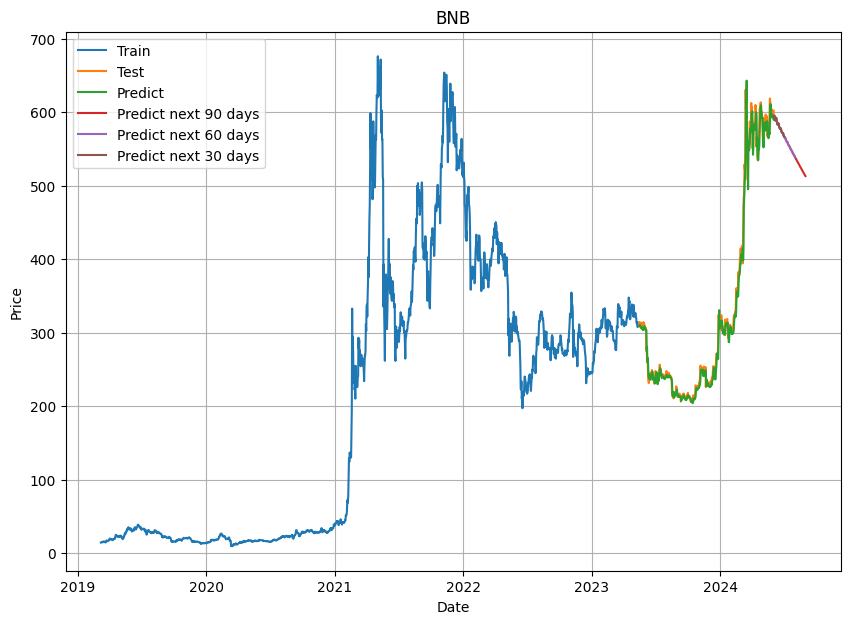

In [143]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 7. BTC/USD Dataset (Data split 9:1)

In [42]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [44]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [45]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [46]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [47]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [49]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [50]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [51]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 134101.4531 - mae: 134101.4531 - mse: 52425850880.0000 - val_loss: 165807.3125 - val_mae: 165807.3125 - val_mse: 28814260224.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - loss: 55674.8711 - mae: 55674.8711 - mse: 6143345664.0000 - val_loss: 16912.4941 - val_mae: 16912.4941 - val_mse: 317208992.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - loss: 9567.9717 - mae: 9567.9717 - mse: 141268656.0000 - val_loss: 22524.6699 - val_mae: 22524.6699 - val_mse: 547814336.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step - loss: 9511.8916 - mae: 9511.8916 - mse: 148645648.0000 - val_loss: 15604.8232 - val_mae: 15604.8232 - val_mse: 259608256.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - loss: 5594.0884 - mae: 5594.0884 - mse: 57572556.0000 - val_loss: 5406.9912 - val_mae: 5406.9912 - val_mse: 36815572.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - loss: 2106.0659 - mae: 2106.0659 - mse: 93295

In [52]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


array([36545.97 , 36498.34 , 36882.25 , 37271.02 , 36718.89 , 36733.926,
       36932.73 , 37102.074, 37068.85 , 37739.13 ], dtype=float32)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.610017466813545
RMSE: 1922.360714991871
MAE: 1451.2233642578128


In [54]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [55]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 67308.3046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [69440.        68374.        67652.4       68352.2       67548.
 67768.5       67308.3046875] -> Prediction: 67850.2890625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [68374.        67652.4       68352.2       67548.        67768.5
 67308.3046875 67850.2890625] -> Prediction: 66837.5234375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       67308.3046875
 67850.2890625 66837.5234375] -> Prediction: 66605.8203125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [68352.2       67548.        67768.5       67308.3046875 67850.2890625
 66837.5234375 66605.8203125] -> Prediction: 66737.8828125


In [56]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [57]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

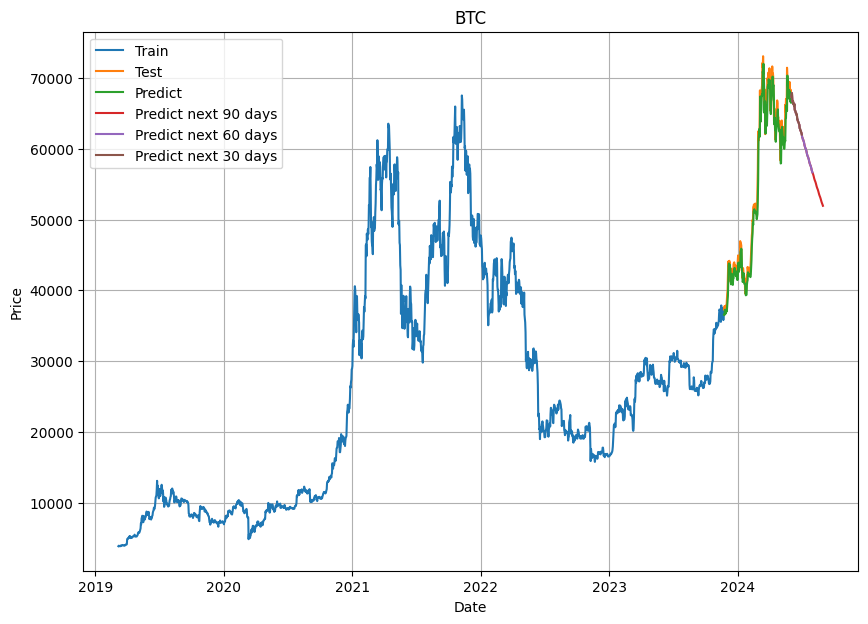

In [58]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 8. ETH/USD Dataset (Data split 9:1)

In [91]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [93]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [94]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [95]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [96]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [97]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [98]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [99]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 8369.7715 - mae: 8369.7715 - mse: 221763824.0000 - val_loss: 7017.1733 - val_mae: 7017.1733 - val_mse: 51308944.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 728ms/step - loss: 2499.1868 - mae: 2499.1868 - mse: 14547761.0000 - val_loss: 5610.8794 - val_mae: 5610.8794 - val_mse: 33606736.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 760ms/step - loss: 2024.0835 - mae: 2024.0835 - mse: 9909608.0000 - val_loss: 654.3751 - val_mae: 654.3751 - val_mse: 489825.9062
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step - loss: 433.5020 - mae: 433.5020 - mse: 391827.0625 - val_loss: 146.6571 - val_mae: 146.6571 - val_mse: 39995.6133
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 738ms/step - loss: 162.0509 - mae: 162.0509 - mse: 64397.7617 - val_loss: 213.7670 - val_mae: 213.7670 - val_mse: 68331.9297
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 739ms/step - loss: 147.6132 - mae: 147.6132 - mse: 54057.3789 - val_loss: 128.9774 - val_mae: 128.9774 - val_m

In [100]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


array([2056.74  , 2122.0908, 2100.8284, 2102.4448, 2088.4727, 2091.3257,
       2075.8176, 2069.013 , 2077.1858, 2097.0942], dtype=float32)

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.724850737029483
RMSE: 112.8024773701639
MAE: 80.66616622924803


In [102]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [103]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3897.385986328125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3897.38598633] -> Prediction: 3910.010498046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3897.38598633 3910.01049805] -> Prediction: 3864.84619140625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3897.38598633
 3910.01049805 3864.84619141] -> Prediction: 3828.330322265625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3897.38598633 3910.01049805
 3864.84619141 3828.33032227] -> Predict

In [104]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [105]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

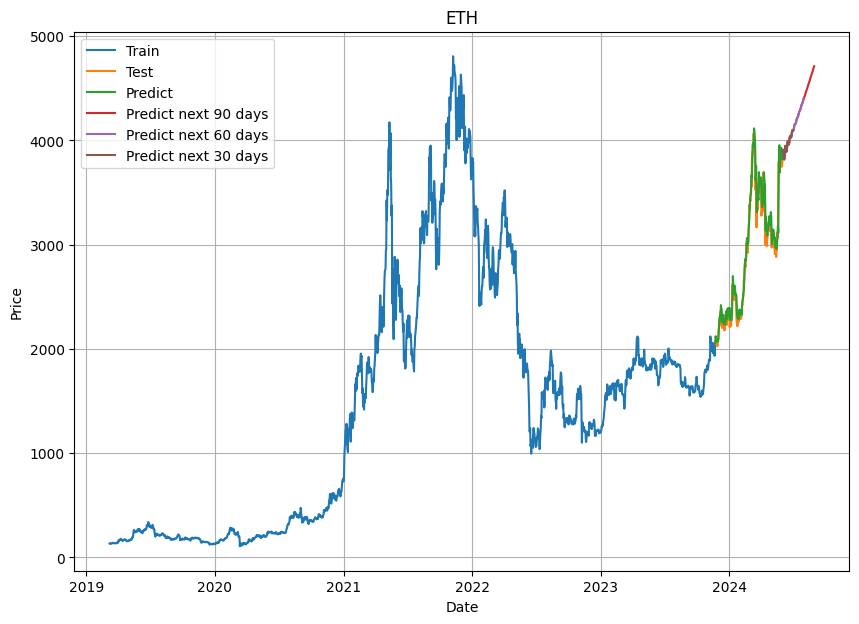

In [106]:

# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 9. BNB/USD Dataset (Data split 9:1)

In [144]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [145]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [146]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [147]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [148]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [149]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [150]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [151]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [152]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 1301.9828 - mae: 1301.9828 - mse: 5461845.5000 - val_loss: 1063.4608 - val_mae: 1063.4608 - val_mse: 1266808.1250
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 763ms/step - loss: 334.1256 - mae: 334.1256 - mse: 303248.0938 - val_loss: 301.1770 - val_mae: 301.1770 - val_mse: 103224.6641
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 778ms/step - loss: 114.3701 - mae: 114.3701 - mse: 32414.7969 - val_loss: 92.9384 - val_mae: 92.9384 - val_mse: 10272.5078
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step - loss: 53.1499 - mae: 53.1499 - mse: 6065.4443 - val_loss: 24.1872 - val_mae: 24.1872 - val_mse: 878.2569
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 759ms/step - loss: 25.5155 - mae: 25.5155 - mse: 1750.9102 - val_loss: 37.5718 - val_mae: 37.5718 - val_mse: 1773.8600
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 833ms/step - loss: 13.3764 - mae: 13.3764 - mse: 605.7177 - val_loss: 128.1913 - val_mae: 128.1913 - val_mse: 19211.0234
Epoch 7/100
2/2 ━━━━━

In [153]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


array([233.6644 , 231.3007 , 230.93692, 232.08154, 229.30475, 225.61732,
       227.427  , 225.73544, 225.7515 , 225.82237], dtype=float32)

In [154]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.540816143124217
RMSE: 16.5412259508481
MAE: 11.159295336405435


In [155]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [156]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 592.0328369140625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        592.03283691] -> Prediction: 594.58056640625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 592.03283691 594.58056641] -> Prediction: 591.3370361328125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        592.03283691
 594.58056641 591.33703613] -> Prediction: 587.7860717773438

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [595.         593.8        601.8        592.03283691 594.58056641
 591.33703613 587.78607178] -> Prediction: 586.6474609375

1/1 ━━━━━━━━━━━━━━━━━━━━

In [157]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [158]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

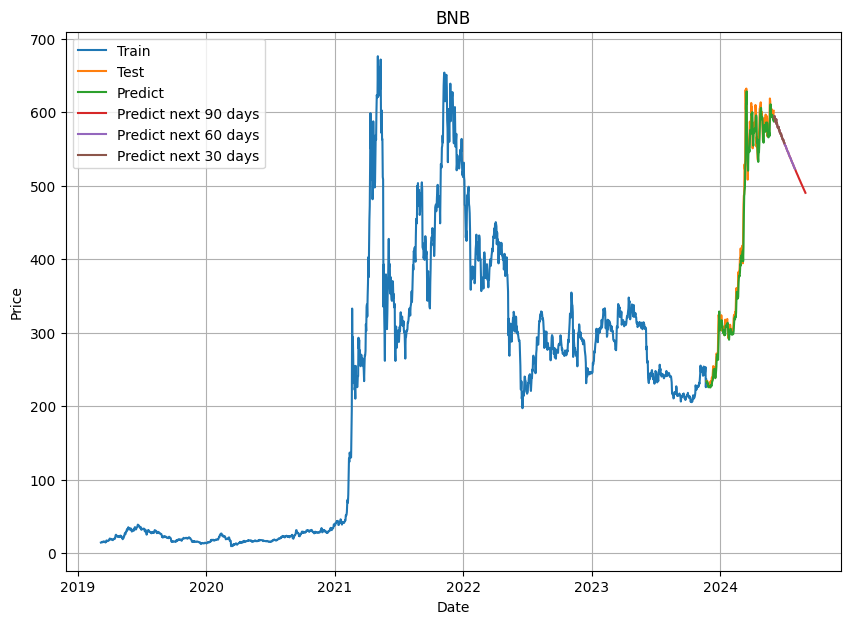

In [159]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')
plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()